In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_2_1'

In [2]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [3]:
%%sh -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j

Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
make[1]: '.dep' is up to date.
Building for platform CWLITEARM with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10-2020-q4-major) 10.2.1 20201103 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Welcome to another exciting ChipWhisperer target build!!
.
Assembling: .././hal/stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length

In [4]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6163 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6163 bytes


In [5]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

In [6]:
import ctypes
import numpy as np
from picosdk.ps2000a import ps2000a as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico_ok
import time

#general settings for api/scope
chandle = ctypes.c_int16()
status = {}
enabled = 1
disabled = 0
analogue_offset = 0.0
nextSample = 0
wasCalledBack = False
maxPreTriggerSamples = 0
channel_rangeA = ps.PS2000A_RANGE['PS2000A_50MV']
channel_rangeB = ps.PS2000A_RANGE['PS2000A_2V']

# Size of capture
totalSamples = 5000

status["openunit"] = ps.ps2000aOpenUnit(ctypes.byref(chandle), None) 
assert_pico_ok(status["openunit"])

status["setChA"] = ps.ps2000aSetChannel(chandle,
                                        ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A'],
                                        enabled,
                                        ps.PS2000A_COUPLING['PS2000A_AC'],
                                        channel_rangeA,
                                        analogue_offset)
assert_pico_ok(status["setChA"])

status["setChB"] = ps.ps2000aSetChannel(chandle,
                                        ps.PS2000A_CHANNEL['PS2000A_CHANNEL_B'],
                                        enabled,
                                        ps.PS2000A_COUPLING['PS2000A_AC'],
                                        channel_rangeB,
                                        analogue_offset)
assert_pico_ok(status["setChB"])

In [11]:
# Create buffers ready for assigning pointers for data collection
bufferCompleteA = np.zeros(shape=totalSamples, dtype=np.int16)

memory_segment = 0

    # Set data buffer location for data collection from channel A
    # handle = chandle
    # source = PS2000A_CHANNEL_A = 0
    # pointer to buffer max = ctypes.byref(bufferAMax)
    # pointer to buffer min = ctypes.byref(bufferAMin)
    # buffer length = maxSamples
    # segment index = 0
    # ratio mode = PS2000A_RATIO_MODE_NONE = 0
status["setDataBuffersA"] = ps.ps2000aSetDataBuffers(chandle,
                                                        ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A'],
                                                        bufferCompleteA.ctypes.data_as(ctypes.POINTER(ctypes.c_int16)),
                                                        None,
                                                        totalSamples,
                                                        memory_segment,
                                                        ps.PS2000A_RATIO_MODE['PS2000A_RATIO_MODE_NONE'])
assert_pico_ok(status["setDataBuffersA"])

In [16]:
def pico_arm(chandle): 
    
    status["setTriggerB"] = ps.ps2000aSetSimpleTrigger(chandle,
                                                  enabled,
                                                  ps.PS2000A_CHANNEL['PS2000A_CHANNEL_B'],
                                                  channel_rangeB, 
                                                  2, #rising edge
                                                  0, #delay
                                                  0) #auto trigger
    assert_pico_ok(status["setTriggerB"])
    
    
    status["runStreaming"] = ps.ps2000aRunStreaming(chandle,
                                                ctypes.byref(sampleInterval),
                                                sampleUnits,
                                                maxPreTriggerSamples,
                                                totalSamples,
                                                autoStopOn,
                                                downsampleRatio,
                                                ps.PS2000A_RATIO_MODE['PS2000A_RATIO_MODE_NONE'],
                                                totalSamples)
    assert_pico_ok(status["runStreaming"])
    

In [34]:
def streaming_callback(handle, noOfSamples, startIndex, overflow, triggerAt, triggered, autoStop, param):
    global pico_array, autoStopOuter
    if triggered:
        pico_array.append(bufferCompleteA)
        autoStopOuter = False


# Convert the python function into a C function pointer.
cFuncPtr = ps.StreamingReadyType(streaming_callback)

In [35]:
#For converting ADC values to mV later on
maxADC = ctypes.c_int16()
status["maximumValue"] = ps.ps2000aMaximumValue(chandle, ctypes.byref(maxADC))
assert_pico_ok(status["maximumValue"])

In [46]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []
pico_array = []

key, text = ktp.next()

target.set_key(key)
print(key)

#######################BEGIN PICOSCOPE
# Begin streaming mode:
sampleInterval = ctypes.c_int32(100)
sampleUnits = ps.PS2000A_TIME_UNITS['PS2000A_US']
autoStopOn = 0
# No downsampling:
downsampleRatio = 1


actualSampleInterval = sampleInterval.value
actualSampleIntervalNs = actualSampleInterval * 1000

print("Capturing at sample interval %s ns" % actualSampleIntervalNs)

N = 250
for i in tnrange(N, desc='Capturing traces'):
    autoStopOuter = True
    scope.arm()
    pico_arm(chandle)
    while autoStopOuter == True:
        target.simpleserial_write('p', text)
        status["getStreamingLastestValues"] = ps.ps2000aGetStreamingLatestValues(chandle, cFuncPtr, None)
        time.sleep(0.01)
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    # Stop the scope
    # handle = chandle
    status["stop"] = ps.ps2000aStop(chandle)
    assert_pico_ok(status["stop"])
    key, text = ktp.next()
    #time.sleep(0.01)

numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace

# Stop the scope
# handle = chandle
status["stop"] = ps.ps2000aStop(chandle)
assert_pico_ok(status["stop"])


CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
Capturing at sample interval 100000 ns


C:\Users\dynko\AppData\Local\Temp\ipykernel_2416\3112758268.py:30: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/250 [00:00<?, ?it/s]

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 61 got 236
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 216
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 112
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 70 7c db 93 81 a8 c7 55 00 03 65 01 02 eb 00 08 72 10 da 9c a4 c2 2a 0c b7 e9 4f 4b 2c 7f cf 7e 0b b0 c7 00 03 65 01 02 eb 00 14 72 10 a0 ce 14 8b 16 67 73 3f c0 c4 8c 2f 57 b7 ee 2f 90 00 03 65 01 02 eb 00 14 72 10 44 50 96 9f 69 92 e1 1b 73 be aa 56 de 68 2b 1b b2 00 03 65 01 02 eb 00 14 72 10 ef 6b 0e 5c 7c cd 36 4d 68 e4 5c 46 6e 05 d6 96 1b 00 03 65 01 02 eb 00 14 72 10 84 c4')


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 134 got 132
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 196
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0xdb
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 70 7c db 93 81 a8 c7 55 00 03 65 01 02 eb 00 08 72 10 da 9c a4 c2 2a 0c b7 e9 4f 4b 2c 7f cf 7e 0b b0 c7 00 03 65 01 02 eb 00 14 72 10 a0 ce 14 8b 16 67 73 3f c0 c4 8c 2f 57 b7 ee 2f 90 00 03 65 01 02 eb 00 14 72 10 44 50 96 9f 69 92 e1 1b 73 be aa 56 de 68 2b 1b b2 00 03 65 01 02 eb 00 14 72 10 ef 6b 0e 5c 7c cd 36 4d 68 e4 5c 46 6e 05 d6 96 1b 00 03 65 01 02 eb 00 14 72 10 84 c4')


Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 242 got 235
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 135
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 155
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 9b 97 d4 7c d8 2e eb 1e 00 03 65 01 02 eb 00 14 72 10 d7 a0 5d 4b 6d 61 9a 45 8a 12 6e 4e 48 69 1b ce bc 00 03 65 01 02 eb 00 14 72 10 54 ba 9e 7f 06 55 0a 37 2b a3 a5 19 16 9e 2c fb 5c 00 03 65 01 02 eb 00 14 72 10 db 9e 4c 9c 68 e6 ba 47 2b 6f 47 5b 87 09 3c 28 74 00 03 65 01 02 eb 00 14 72 10 f5 a5 10 6e 52 01 7a b2 9e d4 22 04 57 a2 f5 bf 08 00 03 65 01 02 eb 00 14 72 10 20 b4 1e b8 01 e9 28 77 7f 2e 2b 3b cb cf 89 1b 37 00 03 65 01 02 eb 00 14 72 10 18 72')


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 114
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0xd4
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 9b 97 d4 7c d8 2e 00 1e 00 03 65 01 02 eb 00 14 72 10 d7 a0 5d 4b 6d 61 9a 45 8a 12 6e 4e 48 69 1b ce bc 00 03 65 01 02 eb 00 14 72 10 54 ba 9e 7f 06 55 0a 37 2b a3 a5 19 16 9e 2c fb 5c 00 03 65 01 02 eb 00 14 72 10 db 9e 4c 9c 68 e6 ba 47 2b 6f 47 5b 87 09 3c 28 74 00 03 65 01 02 eb 00 14 72 10 f5 a5 10 6e 52 01 7a b2 9e d4 22 04 57 a2 f5 bf 08 00 03 65 01 02 eb 00 14 72 10 20 b4 1e b8 01 e9 28 77 7f 2e 2b 3b cb cf 89 1b 37 00 03 65 01 02 eb 00 14 72 10 18 72')


Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 244 got 213
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 187
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 54


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:528) Didn't get all data 175, 221
(ChipWhisperer Target WARNING|File SimpleSerial2.py:529) CWbytearray(b'1f 5e f2 10 d1 e5 00 03 65 01 02 eb 00 14 72 10 35 ce e4 84 27 7d 7a 10 0b 3e 6f f7 42 87 4b 0d 21 00 03 65 01 02 eb 00 14 72 10 23 2f 78 1e 53 11 49 3d 89 9b f2 9e ee 12 a1 97 c9 00 03 65 01 02 eb 00 14 72 10 f8 0b 66 2a 94 df bd fb d1 7c 1d 77 a5 75 03 fa ad 00 03 65 01 02 eb 00 14 72 10 6e c5 4a 0a cb 05 a2 b9 fb bf 66 55 68 76 22 97 56 00 03 65 01 02 eb 00 10 72 10 a4 5d 09 45 b0 84 ad d9 7e a6 bf 69 9b 04 2f 8e 2d 00 03 65 01 02 eb 00 14 72 10 db 84 0f 1a c2 7c b3 f4 cc ba 5d 86 55 bd 49 ab f3 00 03 65 01 02 eb 00')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:530) CWbytearray(b'00 36 db')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 36 db 1f 5e f2 10 d1 e5 00 03 65 01 02 eb 00 14 72 10 35 ce e4 84 27 7d 7a 10 0b 3e 6f f7 42 87 4b 0d 21 00 03 65 01 02 eb 00 14 72 10 

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 251 got 0
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 66
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 123
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 7b 9d c1 61 b4 38 74 cb 00 03 65 01 02 eb 00 14 72 10 63 4e 8c d5 8a 6f 4f c3 5e 90 a2 a9 11 b6 51 c2 43 00 03 65 01 02 eb 00 14 72 10 9b a2 52 02 5a 8f ba 49 27 f8 76 06 2c 16 21 4a 4f 00 03 65 01 02 eb 00 14 72 10 0e 36 77 d0 eb 92 b5 ae 9e 6e f3 84 7a 06 01 5f d4 00 03 65 01 02 eb 00 14 72 10 a4 0c e7 d6 fc 14 68 9e e8 44 ee 20 21 c7 a2 e5 6e 00 03 65 01 02 eb 00 14 72 10 cd 16 ff 8f cb 48 f0 45 e6 25 34 73 1d c4 d5 cf 6d 00 03 65 01 02 eb 00 14 72 10 77 69 b8 da da 16 ff 0a')


Im triggered!


(ChipWhisperer Target ERROR|File SimpleSerial2.py:189) bytearray(b'\x00\xeb\x00\x14r\x10\xa4\x0c\xe7\xd6\xfc\x14h\x9e\xe8D\xee !\xc7\xa2\xe5n\x00\x03e\x01\x02\xeb\x00\x14r\x10\xcd\x16\xff\x8f\xcbH\xf0E\xe6%4s\x1d\xc4\xd5\xcfm\x00\x03e\x01\x02\xeb\x00\x14r\x10wi\xb8\xda\xda\x16\xff\n'), 2, 0
(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 144 got 255
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 10
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0xc1
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 7b 9d c1 61 b4 38 74 cb 00 03 65 01 02 eb 00 14 72 10 63 4e 8c d5 8a 6f 4f c3 5e 90 a2 a9 11 b6 51 c2 43 00 03 65 01 02 eb 00 14 72 10 9b a2 52 02 5a 8f ba 49 27 f8 76 06 2c 16 21 4a 4f 00 03 65 01 02 eb 00 14 72 10 0e 36 77 d0 eb 92 b5 ae 9e 6e f3 84 7a 06 01 5f d4 00 03 65 01 00 eb 00 14 72 10 a4 0c e7 d6 fc 14 68 9e e8 44 ee 20 21 c7 a2 e5 6e 00 03 65 01 02 eb 00 

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 228 got 71
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 10
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 146
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 92 79 98 a1 d2 e9 e3 6a 00 03 65 01 02 eb 00 14 72 10 af 2e f2 2e 2f e9 76 11 8e be 77 8b 3f b6 9b f7 8a 00 03 65 01 02 eb 00 14 72 10 33 ba 79 80 2b 7b bd b4 75 04 35 a2 0e 69 3c a6 72 00 03 65 01 02 eb 00 14 72 10 a9 42 5c 22 21 44 06 ae ed 38 cb 96 12 81 3c 85 7a 00 03 65 01 02 eb 00 14 72 10 2b d2 91 0e 62 db 3b 96 aa f3 d1 47 7a 0a 60 44 f3 00 03 65 01 02 eb 00 06 72')


Im triggered!


(ChipWhisperer Target ERROR|File SimpleSerial2.py:189) bytearray(b'\x00\xb6\x9b\xf7\x8a\x00\x03e\x01\x02\xeb\x00\x14r\x103\xbay\x80+{\xbd\xb4u\x045\xa2\x0ei<\xa6r\x00\x03e\x01\x02\xeb\x00\x14r\x10\xa9B\\"!D\x06\xae\xed8\xcb\x96\x12\x81<\x85z\x00\x03e\x01\x00\xeb\x00\x14r\x10+\xd2\x91\x0eb\xdb;\x96\xaa\xf3\xd1Gz\n`D\xf3\x00\x03e\x01\x02\xeb\x00\x06r'), 65, 0
(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 244 got 6
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 114
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x98
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 92 79 98 a1 d2 e9 e3 6a 00 03 65 01 02 eb 00 14 72 10 af 2e f2 2e 2f e9 76 11 8e be 77 8b 00 b6 9b f7 8a 00 03 65 01 02 eb 00 14 72 10 33 ba 79 80 2b 7b bd b4 75 04 35 a2 0e 69 3c a6 72 00 03 65 01 02 eb 00 14 72 10 a9 42 5c 22 21 44 06 ae ed 38 cb 96 12 81 3c 85 7a 00 03 65 01 00 eb 00 14 72 10 2b d2

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 44 got 245
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 236
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 67
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 43 77 2c 74 94 a4 86 6a 00 03 65 01 02 eb 00 14 72 10 e4 30 46 6d 02 96 ca a8 15 87 91 6a d5 c3 13 9c 8a 00 03 65 01 02 eb 00 14 72 10 0f ee 05 61 0b 70 af 05 0f 24 ef 7d 54 7a 37 3d e3 00 03 65 01 02 eb 00 14 72 10 48 b6 dc 9a bf df 6a 44 c7 8b f3 3c 5b 1d 14 09 44 00 03 65 01 02 eb 00 14 72 10 6a e0 d5 86 c1 da 11 ff 58 d5 98 cd 16 bb bc ed 23 00 03 65 01 02 eb 00')


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 78 got 235
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x2c
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 43 77 2c 74 94 a4 86 6a 00 03 65 01 02 eb 00 14 72 10 e4 30 46 6d 02 96 ca a8 15 87 91 6a d5 c3 13 9c 8a 00 03 65 01 02 eb 00 14 72 10 0f ee 05 61 0b 70 af 05 0f 24 ef 7d 54 7a 37 3d e3 00 03 65 01 02 eb 00 14 72 10 48 b6 dc 9a bf df 6a 44 c7 8b f3 3c 5b 1d 14 09 44 00 03 65 01 02 eb 00 14 72 10 6a e0 d5 86 c1 da 11 ff 58 d5 98 cd 16 bb bc ed 23 00 03 65 01 02 eb 00')


Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 151 got 6
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 75
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 195


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:528) Didn't get all data 175, 199
(ChipWhisperer Target WARNING|File SimpleSerial2.py:529) CWbytearray(b'88 cf df d3 3b 89 00 03 65 01 02 eb 00 14 72 10 48 21 38 27 bf a4 cc 89 2a 6f 28 6d e7 81 07 de 76 00 03 65 01 02 eb 00 14 72 10 69 ef 66 20 08 6c d4 3f 11 a4 ad 66 f8 5f 81 83 5a 00 03 65 01 02 eb 00 14 72 10 bb 21 a7 d1 d1 2b be 9b 3f fe 3c e9 82 cd 95 4f 3c 00 03 65 01 02 eb 00 14 72 10 a6 d0 85 f0 ae ab c3 e7 c1 b4 8a 44 05 79 d0 32 41 00 03 65 01 02 eb 00 14 72 10 2c d1 76 72 35 6a 9b 89 c4 51 d4 57 88 3d 4f 7b 18 00 03 65 01 02 eb 00 09 72 10 2d 46 78 7b c1 60 0b 80 7f 1e e5 ee 0e 66 2a 7c bf 00 03 65 01 02 eb 00')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:530) CWbytearray(b'00 c3 c5')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 c3 c5 88 cf df d3 3b 89 00 03 65 01 02 eb 00 14 72 10 48 21 38 27 bf a4 cc 89 2a 6f 28 6d e7 81 07 de 76 00 03 65 01 02 eb 00 14 72 10 

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 21 got 211
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 126
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 11
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 0b 14 cc 77 1f da 9b bd 00 03 65 01 02 eb 00 14 72 10 9e 15 90 5a 4f ed')


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 232 got 79
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 237
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0xcc
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 0b 14 cc 77 1f da 9b bd 00 03 65 01 02 eb 00 14 72 10 9e 15 90 5a 4f ed')


Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 22 got 169
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 188
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 153
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 99 88 23 3a 5d e1 90 66 00 03 65 01 02 eb 00 14 72 10 3d 40 a3 6b 3c a3 3f 2b 99 0e f0 fd e2 9f ed fc 8e 00 03 65 01 02 eb 00 14 72 10 a2 45 5b e0 90 57 62 11 db b0 9d a3 36 2a 0d d4 47 00 03 65 01 02 eb 00 14 72 10 f3 2a 3e f4 2d 15 c6 d4 d8 b6 36 1e 1b f5 fd c3 c5 00 03 65 01 02 eb 00 14 72 10 f9 b6 9a b7 12 5e 05 a2 c1 1b e5 b9 15 5d ee 9f 74 00 03 65 01 02 eb 00 14 72 10 50 a9 6f 8b 29 37 02 e2 1d 2b 91 3b f3 47')


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 178 got 243
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 71
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x23
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 99 88 23 3a 5d e1 90 66 00 03 65 01 02 eb 00 14 72 10 3d 40 a3 6b 3c a3 3f 2b 99 0e f0 fd e2 9f ed fc 8e 00 03 65 01 02 eb 00 14 72 10 a2 45 5b e0 90 57 62 11 db b0 9d a3 36 2a 0d d4 47 00 03 65 01 02 eb 00 14 72 10 f3 2a 3e f4 2d 15 c6 d4 d8 b6 36 1e 1b f5 fd c3 c5 00 03 65 01 02 eb 00 14 72 10 f9 b6 9a b7 12 5e 05 a2 c1 1b e5 b9 15 5d ee 9f 74 00 03 65 01 02 eb 00 14 72 10 50 a9 6f 8b 29 37 02 e2 1d 2b 91 3b f3 47')


Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 156 got 79
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 217
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 125


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:528) Didn't get all data 175, 182
(ChipWhisperer Target WARNING|File SimpleSerial2.py:529) CWbytearray(b'96 2f 0f 0d 45 01 00 03 65 01 02 eb 00 14 72 10 e6 37 e6 92 c7 ea 1e 75 79 ea 08 7c 54 83 18 3f 1e 00 03 65 01 02 eb 00 14 72 10 8b b8 09 7e 51 d1 c0 bb ca 86 48 c3 a4 12 0d 5c 3e 00 03 65 01 02 eb 00 08 72 10 e7 08 a3 82 24 0c 27 af ea 5f 99 bd 1d a0 8d ca 11 00 03 65 01 02 eb 00 14 72 10 f8 fc e7 80 d1 dd c4 a9 f5 87 51 a5 36 07 e2 15 d7 00 03 65 01 02 eb 00 14 72 10 56 c4 d5 18 92 46 be a0 51 a3 dc a7 05 a7 03 68 56 00 03 65 01 02 eb 00 14 72 10 bb 53 38 56 09 e2 b4 ea 50 6e 0e 40 c5 12 dc 0d 37 00 03 65 01 02 eb 00')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:530) CWbytearray(b'00 7d b4')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 7d b4 96 2f 0f 0d 45 01 00 03 65 01 02 eb 00 14 72 10 e6 37 e6 92 c7 ea 1e 75 79 ea 08 7c 54 83 18 3f 1e 00 03 65 01 02 eb 00 14 72 10 

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 20 got 39
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 244
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 155
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 9b a0 f6 b7 13 70 8e 12 00 03 65 01 02 eb 00 14 72 10 23 0d e6 2d 05 16 7c 6c 81 40 5d 62 19 9b 22 3d 8a 00 03 65 01 02 eb 00 14 72 10 ca 8c 8a 31 a0 c6 28 c1 b3 f0 41 99 48 64 04 c8 02 00 03 65 01 02 eb 00 14 72 10 af 3d 07 bf 4c 0f 87 ef 9d f9 78 0a 63 d7 62 42 b7 00 03 65 01 02 eb 00 14 72 10 ea 86 04 a5 98 65 cd 0a 74 ac 85 e1 49 36 7b c3 b5 00 03 65 01 02 eb 00 14 72 10 12 69 78 09 f6 23 7e 15 1a b6 03 d3 8d 29 6c a0 52 00 03 65 01 02 eb 00 14 72 10 6c 37 b9 ae c2 12 43 bc 5f bd 1e')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 122 got 189
(ChipWhisperer Target WARNING|File SimpleSe

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 15 got 64
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 11
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 199
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 c7 a8 1b 6e f7 46 fc 43 00 03 65 01 02 eb 00 14 72 10 c8 a8 74 92 2d 1b 3f 28 70 12 d4 4f 6e 72 5c 41 77 00 03 65 01 02 eb 00 14 72 10 b7 25 76 9a 2d 4b fe c7 a6 aa b9 55 76 0d a6 84 23 00 03 65 01 02 eb 00 14 72 10 85 6e 1a e4 14 e8 fa da 08 fb 38 35 9e 36 38 a1 e5 00 03 65 01 02 eb 00 14 72 10 72 6b ce 9a 4a ba e9 60 77 c2 3d b2 29 1f 38 40 ee 00 03 65 01 02 eb 00 14 72 10 8c ef 6a db 0f ce 03 be ba 71 3b 32 80 08 22 e4 81 00 03 65 01 02 eb 00 14 72 10 48 ee 6b 46 d5 9d 18 a9 d9 a0 eb 12 39 a7 10 05 74 00 03')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:189) bytearray(b'\x00\xeb\x00\x14r\x10H\xeekF\xd5\x9d\x18\xa9

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 5 got 221
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 121
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 119
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 77 31 33 8e 1d 54 10 b0 00 03 65 01 02 eb 00 14 72 10 a4 9a 8d 8b 64 99 e8 b3 ef a0 e5 2e 40 ca e8 61 ad 00 03 65 01 02 eb 00 14 72 10 c4 0c c3 0b 31 98 d5 3e')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 6 got 213
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 62
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x33
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 77 31 33 8e 1d 54 10 b0 00 03 65 01 02 eb 00 14 72 10 a4 9a 8d 8b 64 99 e8 b3 ef a0 e5 2e 40 ca e8 61 ad 00 03 65 01 02 eb 00 14 7

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 246 got 33
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 224
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 144
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 90 6c 6a a9 96 b9 a4 92 00 03 65 01 02 eb 00 14 72 10 cd 68 fb d5 c7 e7 e4 e1 16 fe db e9 7f 08 06 b1 dd 00 03 65 01 02 eb 00 14 72 10 e9 1e c9 57 b1 66 ba bd cc c1 d4 ad 0c 33 b2 b6 ff 00 03 65 01 02 eb 00 14 72 10 da e8 45 65 da 75 f7 c8 ab 26 c2 e2 8a 07 9c 26 5d 00 03 65 01 02 eb 00 14 72 10 19 b4 12 42 60 40 1c e9 45 79 53 76 23')


Im triggered!


(ChipWhisperer Target ERROR|File SimpleSerial2.py:184) Infinite loop in unstuff data
(ChipWhisperer Target ERROR|File SimpleSerial2.py:185) bytearray(b'\x00\x14r\x10\xe9\x1e\xc9W\xb1f\xba\xbd\xcc\xc1\xd4\xad\x0c3\xb2\xb6\xff\x00\x03e\x01\x02\xeb\x00\x14r\x10\xda\xe8Ee\xdau\xf7\xc8\xab&\xc2\xe2\x8a\x07\x9c&]\x00\x03e\x01\x02\xeb\x00\x14r\x10\x19\xb4\x12B`@\x1c\xe9EySv#')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 121 got 118
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 35
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x6a
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 90 6c 6a a9 96 b9 a4 92 00 03 65 01 02 eb 00 14 72 10 cd 68 fb d5 c7 e7 e4 e1 16 fe db e9 7f 08 06 b1 dd 00 03 65 01 02 eb 00 14 72 10 e9 1e c9 57 b1 66 ba bd cc c1 d4 ad 0c 33 b2 b6 ff 00 03 65 01 02 eb 00 14 72 10 da e8 45 65 da 75 f7 c8 ab 26 c2 e2 8a 07 9c 26 5d 00 03 65 01 02 eb 00 

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 171 got 74
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 234
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 166
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 a6 39 58 04 fa ca 8e 87 00 03 65 01 02 eb 00 14 72 10 4b cf 7c cb 5a e7 83 04 22 c5 b5 48 42 18 6a 8f d1 00 03 65 01 02 eb 00 14 72 10 e5 09 19 2e e5 68 07 6f 60 5f 1e 1a 3c 7d 35 e3')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 239 got 53
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 227
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x58
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 a6 39 58 04 fa ca 8e 87 00 03 65 01 02 eb 00 14 72 10 4b cf 7c cb 5a e7 83 04 22 c5 b5 48 42 18 6a 8f d

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 53 got 234
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 175
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 87
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 57 a1 8a 05 eb f1 18 0d 00 03 65 01 02 eb 00 14 72 10 10 f7 e9 53 5c 2e 7c 21 fa 39 c0 39 66 76 b9 b7 84 00 03 65 01 02 eb 00 14 72 10 19 af 27 1e 0b d8 be 67 7a ca 07 30 ef 72 a7 c5 08 00 03 65 01 02 eb 00 14 72 10 cc 70 3b 7f b5 cd 39 7a cf 6a a7 62 22 d9 dd 11 25 00 03 65 01 02 eb 00 14 72 10 a7 53 c5 3c 8e 97 cc a9 c0 70 51 d6 6a ed 90 e4 9c 00 03 65 01 02 eb 00 14 72 10 d9 a0 05 12 48 bd 97 6e 6f 27 c1 8f de 4c f4 f4 6b 00 03 65 01 02 eb 00 14 72 10 fd d4 d1 4b 05 88 2b 17 4a d1 70 32')


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 101 got 112
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 50
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x8a
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 57 a1 8a 05 eb f1 18 0d 00 03 65 01 02 eb 00 14 72 10 10 f7 e9 53 5c 2e 7c 21 fa 39 c0 39 66 76 b9 b7 84 00 03 65 01 02 eb 00 14 72 10 19 af 27 1e 0b d8 be 67 7a ca 07 30 ef 72 a7 c5 08 00 03 65 01 02 eb 00 14 72 10 cc 70 3b 7f b5 cd 39 7a cf 6a a7 62 22 d9 dd 11 25 00 03 65 01 02 eb 00 14 72 10 a7 53 c5 3c 8e 97 cc a9 c0 70 51 d6 6a ed 90 e4 9c 00 03 65 01 02 eb 00 14 72 10 d9 a0 05 12 48 bd 97 6e 6f 27 c1 8f de 4c f4 f4 6b 00 03 65 01 02 eb 00 14 72 10 fd d4 d1 4b 05 88 2b 17 4a d1 70 32')


Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 236 got 29
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 209
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 235
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 eb 29 03 3c f6 61 b0 05 00 03 65 01 02 eb 00 0f 72 10 0b a7 2c 0e 7b e4 66 b9 01 71 c1 bd 05 8c 44 43 42 00 03 65 01 02 eb 00 14 72 10')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 230 got 114
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 16
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x3
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 eb 29 03 3c f6 61 b0 05 00 03 65 01 02 eb 00 0f 72 10 0b a7 2c 0e 7b e4 66 b9 01 71 c1 bd 05 8c 44 43 42 00 03 65 01 02 eb 00 14 72 10')


Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 195 got 101
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 181
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 156
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 9c 6a d3 a5 91 dd 6a 47 00 03 65 01 02 eb 00 14 72 10 ef 9e 18 22 9d fd a7 79 5c df cc b0 78 bc 12 04 22 00 03 65 01 02 eb 00 14 72 10 13 b9 cf 32 a8 6d f3 b3 b4 37 66 76 e7 fe 63 8c 7c 00 03 65 01 02 eb 00 14 72 10 b7 a7 6d 88 b3 49 35 6a 54 7b ba 8c 7d c5 8b 35 e7 00 03 65 01 02 eb 00 14 72 10 fd 1c 2a bb df b2 cb 41 4e 32 d0')
(ChipWhisperer Target ERROR|File SimpleSerial2.py:189) bytearray(b'\x00e\x01\x00\xeb\x00\x14r\x10\xfd\x1c*\xbb\xdf\xb2\xcbAN2\xd0'), 5, 0
(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 125 got 50
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not r

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 161 got 138
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 233
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 163


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:528) Didn't get all data 175, 250
(ChipWhisperer Target WARNING|File SimpleSerial2.py:529) CWbytearray(b'26 6c 1b d3 d2 b6 00 03 65 01 02 eb 00 14 72 10 4c d2 bf 1f 42 ec 4b 1d 66 24 33 37 87 c6 a4 1b 73 00 03 65 01 02 eb 00 14 72 10 22 81 60 6c 7c 5b 90 a0 70 31 f4 0b 3e d1 ec 60 f2 00 03 65 01 02 eb 00 14 72 10 51 1b b1 55 f4 03 e3 42 74 9e 72 fb c9 1a ba 68 1b 00 03 65 01 02 eb 00 13 72 10 14 4e 1d cb de 8c 68 5b 0e d5 f0 1c 8f 6e 0d d0 01 00 03 65 01 02 eb 00 14 72 10 19 59 c1 dc 32 bd f7 0f 1a f1 58 c1 f0 62 28 d0 b4 00 03 65 01 02 eb 00 14 72 10 a2 6b d9 f4 75 66 17 2e a3 12 20 f4 91 2c 2a 2d b7 00 03 65 01 02 eb 00')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:530) CWbytearray(b'00 a3 f8')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 a3 f8 26 6c 1b d3 d2 b6 00 03 65 01 02 eb 00 14 72 10 4c d2 bf 1f 42 ec 4b 1d 66 24 33 37 87 c6 a4 1b 73 00 03 65 01 02 eb 00 14 72 10 

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 115 got 152
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 183
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 91
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 5b a0 8a 70 1f 20 98 4c 00 03 65 01 02 eb 00 14 72 10 b0 17 ed e5 ef 56 5e bc 56 42 b8 d5 52 c6 a8 c5 a0 00 03 65 01 02 eb 00 14 72 10 e5 d9 f4 c7 80 a5 e0 ef 93 e7 86 96 0b 84 98 11 05 00 03 65 01 02 eb 00 14 72 10 a0 17 a2 41 9d f6 ae 07 99 ae 08 05 b7 da a3 48 a4 00 03 65 01 02 eb 00 14 72 10 d1 d7 09 58 51 71 1b ab 62 04 8d 16 1a 9d 6a d9 fc 00 03 65 01 02 eb 00 14 72 10 38 df 8b b9 23 f0 90 ad 98 3e 68 44 65 bf 17 f9 63 00 03 65 01 02 eb 00 14 72 10 28 54 22 3e 89 92 53 48 8c f1 31')


Im triggered!


(ChipWhisperer Target ERROR|File SimpleSerial2.py:189) bytearray(b'\x00r\x10\xb0\x17\xed\xe5\xefV^\xbcVB\xb8\xd5R\xc6\xa8\xc5\xa0\x00\x03e\x01\x02\xeb\x00\x14r\x10\xe5\xd9\xf4\xc7\x80\xa5\xe0\xef\x93\xe7\x86\x96\x0b\x84\x98\x11\x05\x00\x03e\x01\x02\xeb\x00\x14r\x10\xa0\x17\xa2A\x9d\xf6\xae\x07\x99\xae\x08\x05\xb7\xda\xa3H\xa4\x00\x03e\x01\x02\xeb\x00\x14r\x10\xd1\xd7\tXQq\x1b\xabb\x04\x8d\x16\x1a\x9dj\xd9\xfc\x00\x03e\x01\x02\xeb\x00\x14r\x108\xdf\x8b\xb9#\xf0\x90\xad\x98>hDe\xbf\x17\xf9c\x00\x03e\x01\x02\xeb\x00\x14r\x10(T">\x89\x92SH\x8c\xf11'), 20, 0
(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 216 got 241
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 49
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x8a
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 5b a0 8a 70 1f 20 98 4c 00 03 65 01 02 eb 00 00 72 10 b0 17 ed e5 ef 56 5e bc 56 42 b8 d5 52 c6 a8 c5

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 62 got 123
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 141
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 116


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:528) Didn't get all data 175, 190
(ChipWhisperer Target WARNING|File SimpleSerial2.py:529) CWbytearray(b'45 9b 8e 97 7b 06 00 03 65 01 02 eb 00 14 72 10 06 4d 5b 23 72 d5 69 6e 86 db 3a df 67 f3 f9 51 45 00 03 65 01 02 eb 00 14 72 10 e0 dc 02 bd dc 0e 8c 49 ed 74 d1 84 72 a9 9f 9c 60 00 03 65 01 02 eb 00 10 72 10 8c 51 c4 af b8 6b fe db e5 32 ce 2b 42 04 84 80 e1 00 03 65 01 02 eb 00 14 72 10 26 22 ad ae 78 9c c8 b2 c8 f1 52 ea ce e8 6f 7f f9 00 03 65 01 02 eb 00 14 72 10 9e 77 83 e7 ef ec ba 53 9c b5 04 d4 84 d1 05 9a 63 00 03 65 01 02 eb 00 14 72 10 ff ec 9f 42 e0 40 4a c6 ff 1e f2 97 7e 49 d9 4d 5a 00 03 65 01 02 eb 00')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:530) CWbytearray(b'00 74 bc')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 74 bc 45 9b 8e 97 7b 06 00 03 65 01 02 eb 00 14 72 10 06 4d 5b 23 72 d5 69 6e 86 db 3a df 67 f3 f9 51 45 00 03 65 01 02 eb 00 14 72 10 

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 179 got 68
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 62
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 110
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 6e 38 95 6a 0c 93 36 fe 00 03 65 01 02 eb 00 14 72 10 d2 7d 92 5c cf 0a 4c 2d fc 5b d2 f3 56 ec 30 c2 9d 00 03 65 01 02 eb 00 14 72 10 fc 22 4d e2 b1 fa 69 9a 29 0c a1 e1 09 ce ac')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 42 got 206
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 172
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x95
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 6e 38 95 6a 0c 93 36 fe 00 03 65 01 02 eb 00 14 72 10 d2 7d 92 5c cf 0a 4c 2d fc 5b d2 f3 56 ec 30 c2 9d 00

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 174 got 41
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 236
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 105


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:528) Didn't get all data 175, 252
(ChipWhisperer Target WARNING|File SimpleSerial2.py:529) CWbytearray(b'9a 85 32 d4 c0 96 00 03 65 01 02 eb 00 14 72 10 bd d8 37 7b 08 7f cc e1 35 3f 60 d7 e0 59 5d 0a 4d 00 03 65 01 02 eb 00 14 72 10 81 ea 86 25 53 55 f5 3c 58 e8 f2 58 f6 2b 6d a4 1a 00 03 65 01 02 eb 00 14 72 10 a8 af dc 57 12 12 a9 aa d2 cf f3 76 19 8d 7d 80 84 00 03 65 01 02 eb 00 14 72 10 6d f1 31 21 47 1e f0 30 4b 2d 2d 80 f9 da d7 de e6 00 03 65 01 02 eb 00 14 72 10 63 4d 49 0c 48 1e cc 25 ca 5c 91 ba 57 d4 42 92 27 00 03 65 01 02 eb 00 14 72 10 f0 ff 95 f3 0b a7 d3 14 bc 32 f6 df 96 e1 42 36 19 00 03 65 01 02 eb 00')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:530) CWbytearray(b'00 69 fa')
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 69 fa 9a 85 32 d4 c0 96 00 03 65 01 02 eb 00 14 72 10 bd d8 37 7b 08 7f cc e1 35 3f 60 d7 e0 59 5d 0a 4d 00 03 65 01 02 eb 00 14 72 10 

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 186 got 72
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 38
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 179
(ChipWhisperer Target WARNING|File SimpleSerial2.py:528) Didn't get all data 175, 224
(ChipWhisperer Target WARNING|File SimpleSerial2.py:529) CWbytearray(b'57 b4 59 ef ec 26 00 03 65 01 02 eb 00 14 72 10 3a 90 b5 5b 05 ed d1 47 e9 6e f7 6e 3d b6 14 1e 9e 00 03 65 01 02 eb 00 14 72 10 29 68 40 1e c9 b8 e8 63 23 20 28 a3 b8 a5 e9 7d 2c 00 03 65 01 02 eb 00 14 72 10 3d e2 05 08 1a d3 89 e9 9e 49 28 09 79 fc 2d 11 d8 00 03 65 01 02 eb 00 14 72 10 96 54 9d 68 04 6f d4 17 ef 8b 13 90 e8 94 ad 12 25 00 03 65 01 02 eb 00 14 72 10 b2 53 a3 5b 12 b5 04 7f 9e 76 7b b6 83 88 0a 0c 15 00 03 65 01 02 eb 00 14 72 10 64 58 d5 3e 69 46 f1 4e cf 88 13 ca 5c c0 ef 86 68 00 03 65 01 02 eb 00')
(ChipWhisperer Target WARNING|File SimpleSe

Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!
Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 184 got 76
(ChipWhisperer Target WARNING|File SimpleSerial2.py:552) Did not receive end of frame, got 55
(ChipWhisperer Target WARNING|File SimpleSerial2.py:514) Unexpected start to command 233
(ChipWhisperer Target WARNING|File SimpleSerial2.py:536) Unexpected frame byte in CWbytearray(b'00 e9 0b 82 8a 0c 18 1f 1a 00 03 65 01 02 eb 00')


Im triggered!


(ChipWhisperer Target WARNING|File SimpleSerial2.py:549) Invalid CRC. Expected 155 got 235
(ChipWhisperer Target ERROR|File SimpleSerial2.py:288) Device reported error 0x82
(ChipWhisperer Target ERROR|File SimpleSerial2.py:290) CWbytearray(b'00 e9 0b 82 8a 0c 18 1f 1a 00 03 65 01 02 eb 00')


In [47]:
mv_array = adc2mV(pico_array, channel_rangeA, maxADC)

In [48]:
print(len(pico_array))

250


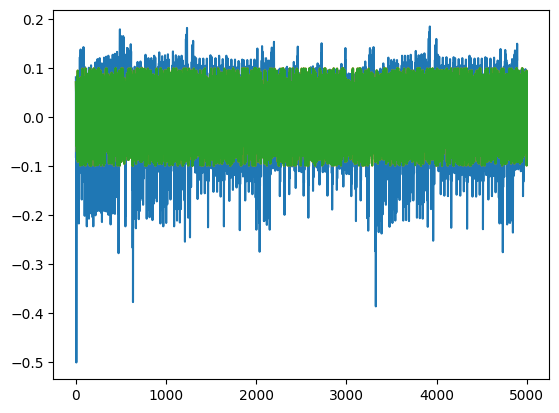

In [51]:
plt.plot(trace_array[1])
plt.plot(mv_array[1] / 10)
plt.plot(mv_array[2] / 10)
plt.show()

In [ ]:
def calculate_diffs(guess, byteindex=0, bitnum=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

        #Mask off the requested bit, most likely LSB
        if hypothetical_leakage & (1<<bitnum):
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    return abs(one_avg - zero_avg)

In [ ]:
#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

for subkey in tnrange(0, 16, desc="Attacking Subkey"): #aka each byte
    max_diffs = [0]*256
    full_diffs = [0]*256
    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey)
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
        
    #Get argument sort, as each index is the actual key guess.
    sorted_args = np.argsort(max_diffs)[::-1]
    
    #Keep most likely
    key_guess.append(sorted_args[0])
    
    #Print results
    print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, key_guess[subkey], known_key[subkey]))
    
    #Print other top guesses
    print(" Top 5 guesses: ")
    for i in range(0, 5):
        g = sorted_args[i]
        print("   %02X - Diff = %f"%(g, max_diffs[g]))
    
    print("\n")

In [52]:
scope.dis()
target.dis()



In [53]:
# Disconnect the scope
# handle = chandle
status["close"] = ps.ps2000aCloseUnit(chandle)
assert_pico_ok(status["close"])